In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Pro_Down_SR

/home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Pro_Down_SR


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
import cv2
import torchvision.transforms as T
import torch.nn.functional as F

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Observation matrix downscale

### Upscale by 4

In [7]:
N_low = 31
N_high = 121
scale = 4
a, b, c = 8,5,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [8]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c)

In [9]:
# Code downscaling matrix
H = np.zeros((N_low*N_low, N_high*N_high))

submatrix = np.zeros((N_low,N_high))
for i in range(N_low):
    submatrix[i,scale*i] = 1
    
for j in range(N_low):
    H[N_low*j:N_low*(j+1),N_high*scale*j:N_high*(scale*j+1)] = submatrix

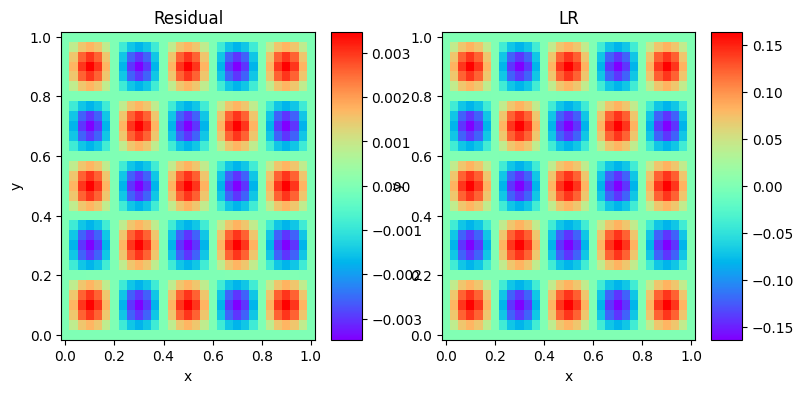

In [10]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, w_low-(H@w_high.reshape(N_high*N_high)).reshape(N_low,N_low), cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Residual')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for RBF kernal
prior_sigma = 0.002
ll_sigma = 0.002

In [12]:
G = np.eye(N_high**2) * prior_sigma**2
G_inverse = np.eye(N_high**2) * (1/prior_sigma**2)

# Turn matrices to tensors
G = torch.tensor(G).to(torch.float32)
G_inverse = torch.tensor(G_inverse).to(torch.float32)
H = torch.tensor(H).to(torch.float32)
A_high = torch.tensor(create_A(N_high)).to(torch.float32)
b_high = torch.tensor(create_forcing_term(N_high,a,b,c)).to(torch.float32)

# Store sparse matrices as sparse tensor
H = H.to_sparse()
A_high = A_high.to_sparse()
G = G.to_sparse()
G_inverse = G_inverse.to_sparse()
operator = torch.spmm(A_high.T,G_inverse)

In [13]:
x = torch.tensor(w_low).to(torch.float32)
posterior_initial = torch.randn(*[N_high,N_high]).to(torch.float32)

In [14]:
# Parameters for Langevin dynamics
K = 3000
s = 0.0004

z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)
for i in range(K):
    # Grad log-likelihood
    x_hat = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    # chains_evolution.append(z.cpu().data.numpy())   

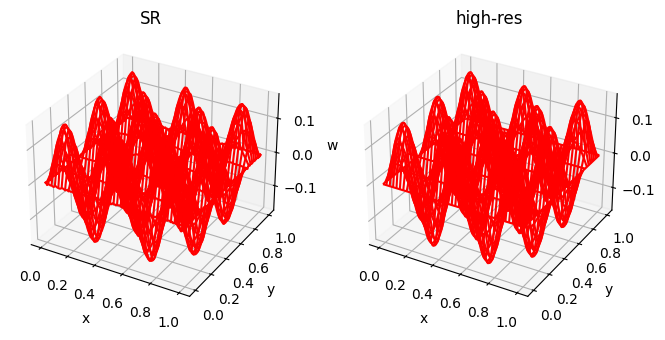

In [15]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [16]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 8.978329676935393e-06


In [ ]:
# Tamed - ULA
z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)
for i in range(2000):
    # Grad log-likelihood
    x_hat = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    grad = grad_ll + grad_log_prior
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad / (1 + 0.5 * s ** 2 * torch.norm(grad)) + s * W
    # chains_evolution.append(z.cpu().data.numpy())   

### Upscale by 6

In [25]:
N_low = 21
N_high = 121
scale = 6
a, b, c = 8,5,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [26]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c)

In [27]:
# Code downscaling matrix
H = np.zeros((N_low*N_low, N_high*N_high))

submatrix = np.zeros((N_low,N_high))
for i in range(N_low):
    submatrix[i,scale*i] = 1
    
for j in range(N_low):
    H[N_low*j:N_low*(j+1),N_high*scale*j:N_high*(scale*j+1)] = submatrix

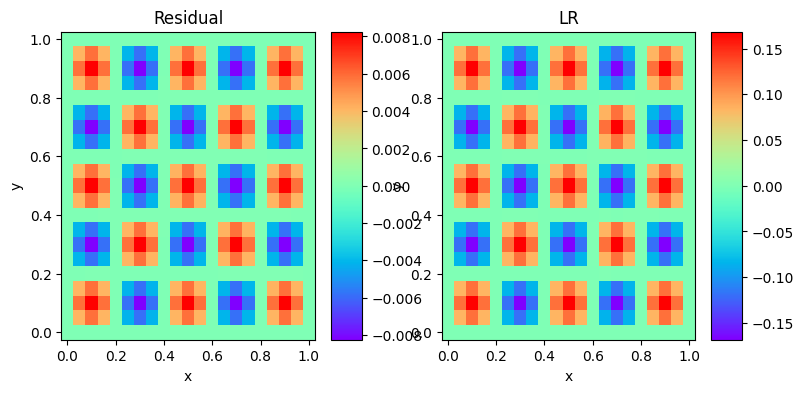

In [28]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, w_low-(H@w_high.reshape(N_high*N_high)).reshape(N_low,N_low), cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Residual')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for RBF kernal
prior_sigma = 0.002
ll_sigma = 0.001

In [30]:
G = np.eye(N_high**2) * prior_sigma**2
G_inverse = np.eye(N_high**2) * (1/prior_sigma**2)

# Turn matrices to tensors
G = torch.tensor(G).to(torch.float32)
G_inverse = torch.tensor(G_inverse).to(torch.float32)
H = torch.tensor(H).to(torch.float32)
A_high = torch.tensor(create_A(N_high)).to(torch.float32)
b_high = torch.tensor(create_forcing_term(N_high,a,b,c)).to(torch.float32)

# Store sparse matrices as sparse tensor
H = H.to_sparse()
A_high = A_high.to_sparse()
G = G.to_sparse()
G_inverse = G_inverse.to_sparse()
operator = torch.spmm(A_high.T,G_inverse)

In [31]:
x = torch.tensor(w_low).to(torch.float32)
posterior_initial = torch.randn(*[N_high,N_high]).to(torch.float32)

In [48]:
# Parameters for Langevin dynamics
K = 4000
s = 0.0004

z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)
for i in range(K):
    # Grad log-likelihood
    x_hat = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    # chains_evolution.append(z.cpu().data.numpy())   

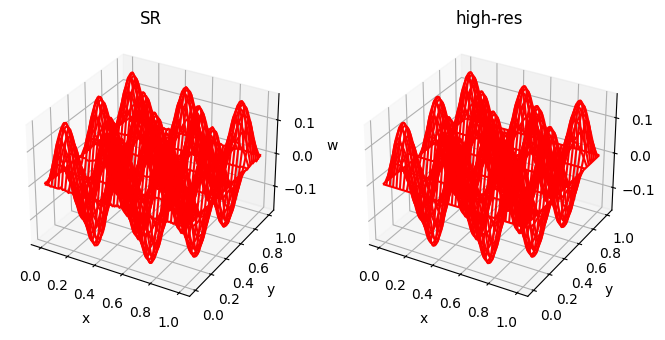

In [49]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [50]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 1.47072924899762e-05


In [ ]:
# Tamed - ULA
z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)
for i in range(2000):
    # Grad log-likelihood
    x_hat = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    grad = grad_ll + grad_log_prior
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad / (1 + 0.5 * s ** 2 * torch.norm(grad)) + s * W
    # chains_evolution.append(z.cpu().data.numpy())   